Data Overview:
         Date        Open        High         Low       Close   Adj Close  \
0  2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
1  2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2  2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
3  2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
4  2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

     Volume  
0  21056800  
1  34483200  
2  37919700  
3  36863600  
4  26580100  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2713 non-null   object 
 1   Open       2713 non-null   float64
 2   High       2713 non-null   float64
 3   Low        2713 non-null   float64
 4   Close      2713 non-null   float64
 5   Adj Close  2713 non-null   float64
 6   Volume 

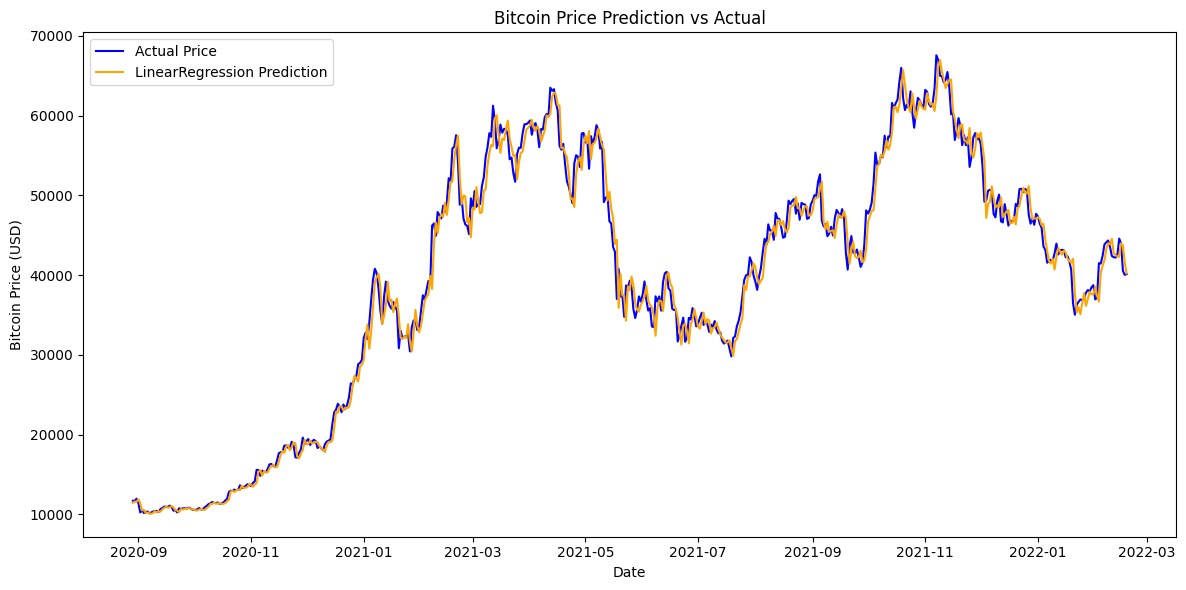

In [2]:
# ==========================
# Bitcoin Price Prediction
# Complete End-to-End ML Pipeline
# ==========================

# 1. Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

# --------------------------
# 2. Load and Inspect Dataset
# --------------------------
# Replace with actual CSV path from Kaggle dataset

#https://drive.google.com/file/d/1myfg4EREaERrqN4iuXsDPCrixpqpGHla/view?usp=sharing
file_id1 = "1myfg4EREaERrqN4iuXsDPCrixpqpGHla"
data_path = f"https://drive.google.com/uc?id={file_id1}"

btc_df = pd.read_csv(data_path)

print("Data Overview:")
print(btc_df.head())
print(btc_df.info())

# --------------------------
# 3. Data Preparation
# --------------------------
# Ensure date column is proper datetime format
btc_df['Date'] = pd.to_datetime(btc_df['Date'], errors='coerce')
btc_df = btc_df.dropna(subset=['Date'])
btc_df = btc_df.sort_values('Date')

# Remove any rows with missing essential values
btc_df = btc_df.dropna()

# Create next-day target price
btc_df['Next_Close'] = btc_df['Close'].shift(-1)

# Feature engineering: Moving averages, volatility, returns
btc_df['MA_7'] = btc_df['Close'].rolling(window=7).mean()
btc_df['MA_21'] = btc_df['Close'].rolling(window=21).mean()
btc_df['Price_Volatility'] = btc_df['Close'].rolling(window=21).std()
btc_df['Daily_Return'] = btc_df['Close'].pct_change()

btc_df = btc_df.dropna()

# --------------------------
# 4. Define Features & Target
# --------------------------
features_list = ['Open', 'High', 'Low', 'Volume',
                 'MA_7', 'MA_21', 'Price_Volatility', 'Daily_Return']
target_var = 'Next_Close'

X = btc_df[features_list]
y = btc_df[target_var]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (no shuffling to maintain time sequence)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)

# --------------------------
# 5. Model Training & Evaluation
# --------------------------
models_to_run = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=250, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=250, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=250, random_state=42)
}

results_summary = {}

for model_name, model in models_to_run.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results_summary[model_name] = {"MAE": mae, "RMSE": rmse, "R2_Score": r2}

# Display results
results_df = pd.DataFrame(results_summary).T
print("\nModel Performance Comparison:")
print(results_df)

# --------------------------
# 6. Visualization of Predictions
# --------------------------
best_model_name = results_df['R2_Score'].idxmax()
best_model = models_to_run[best_model_name]
best_preds = best_model.predict(X_test)

plt.figure(figsize=(12,6))
plt.plot(btc_df['Date'].iloc[-len(y_test):], y_test, label='Actual Price', color='blue')
plt.plot(btc_df['Date'].iloc[-len(y_test):], best_preds, label=f'{best_model_name} Prediction', color='orange')
plt.xlabel("Date")
plt.ylabel("Bitcoin Price (USD)")
plt.title("Bitcoin Price Prediction vs Actual")
plt.legend()
plt.tight_layout()
plt.show()